# TCLab Close loop with PID and FF
## Imports

In [1]:
import numpy as np
import tclab
import time
from datetime import datetime
import os

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import package_DBR
import package_LAB

from importlib import reload
from package_DBR import myRound, SelectPath_RT, Process
from package_LAB import LL_RT, PID_RT,IMC_Tuning, FF_RT, Controller, Margins
package_LAB=reload(package_LAB)

## Parameters

In [2]:
Ts = 1


TSim = 1200
Ts = 1
N = int(TSim / Ts) + 1

# DV MV PV 
DV0 = 50
MV0 = 50
PV0= 54 #  TCLab_PV0_2023-03-30-15h00.txt

# paramètres de ^P(s) 2eme ordre pouvant être considérer comme premier ordre 

Kp =  0.553358040201031 
T1p =  184.504684095101 
T2p =   1.78243605751087E-07 
thetap =  6.19336906382859 

# paramètres de ^D(s) 2ème ordre 
Kd = 0.553358040201031
T1d= 172.259419274141
T2d= 22.1508608750117
thetad =0.533716544751782

#rapport des gains 
KFF = -Kd/Kp

#Coef PID
alpha= 0.9
gamma = 0.9

Kc,T_I,T_D = IMC_Tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print('Kc : ',Kc,'T_I : ',T_I,'T_D',T_D )

#limites
MV_MIN = 0
MV_MAX = 100

Kc :  1.93574448737583 T_I :  184.5046842733446 T_D 1.78243605578892e-07


## Gain and phase margins

indiceGain:  None
indicePhase:  4259
Gain margin :  0.5975851446988621 dB at  0.5050918222052984 rad/s 
Error in the frequency pahse computation 


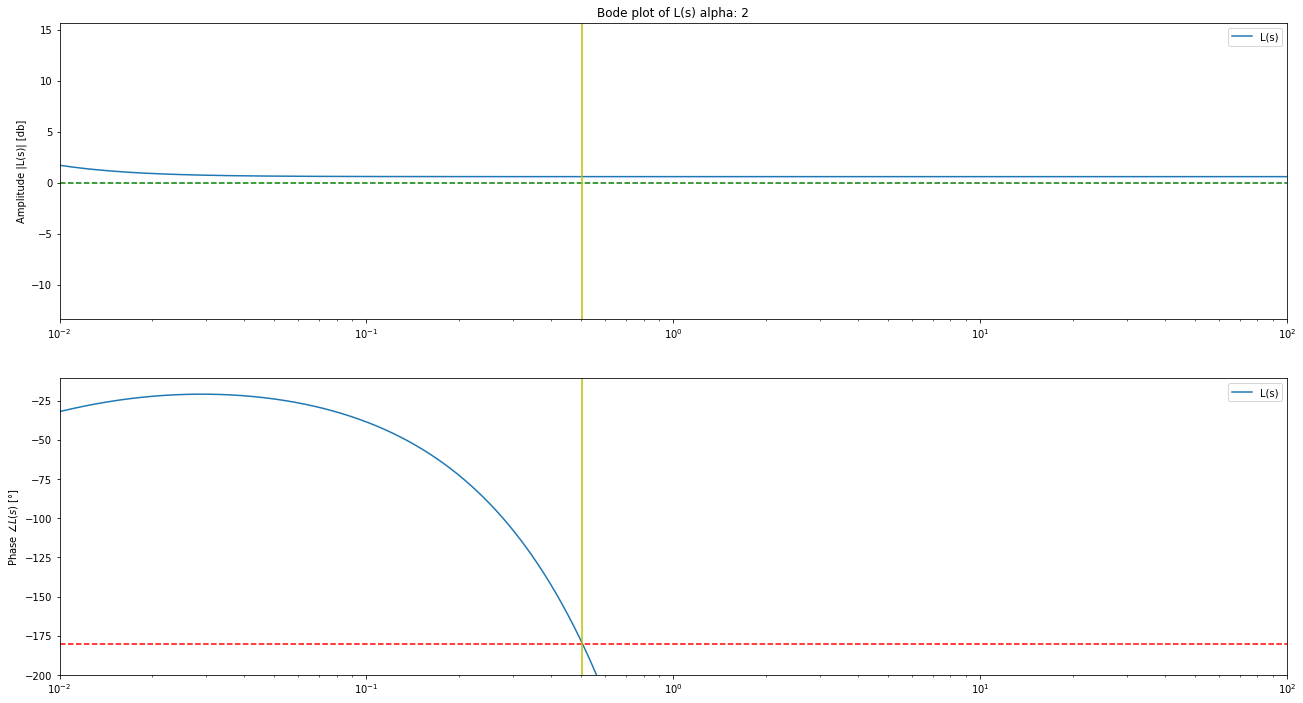

In [3]:
P = Process({})
P.parameters['Kp'] = Kp
P.parameters['theta']=  thetap
P.parameters['Tagd1'] = T1p 
P.parameters['Tlag2'] =  T2p


C = Controller({})

C.parameters['Kc'] = Kc
C.parameters['Ti'] = T_I
C.parameters['Td'] = T_D
C.parameters['alpha'] = alpha


omega = np.logspace(-2, 2, 10000)
try:
    Margins(P,C,omega)
except:
    print('erreur in Margins computation')

## Vectors

In [4]:
Exp = True

t = []
MV = []
PV = []
DV = []
i = 0

t = []
SP = []
DV = []
PV = []
E = []
MV = []
MV_P = []
MV_I = []
MV_D = []
MAN = []
MV_MAN = []

MVFFDelay = []
MVFFLL1 = []
MV_FF = []

PV_LL1 = []
PV_LL2 = []

MVDelayp = []
PV1p = []
PV2p = []

DVDelayd = []
PV1d = []
PV2d = []




## Path mode selection

In [5]:
# Select mode 

#selectmode="OLP_NO_FF"
selectmode="OLP_FF"
#selectmode="CLP_NO_FF"
#selectmode="CLP_FF"
#selectmode="PV0"


In [6]:
# Scenario 1: OLP+ no FF
if selectmode=="OLP_NO_FF":
    ManPath = {0: True, TSim: True}
    MVManPath = {0: 100,60:MV0+20,120:MV0, TSim: MV0}
    SPPath = {0: PV0, TSim: PV0}
    DVPath = {0: DV0+20, 80:DV0, 400: DV0 + 20, 500:DV0, TSim: DV0}
    FF = False
    ManFF = True

# Scenario 2: OLP+ FF
elif selectmode=="OLP_FF":

    ManPath = {0: True, TSim: True}
    MVManPath = {0: 100,60:MV0+20,120:MV0, TSim: MV0}
    SPPath = {0: PV0, TSim: PV0}
    DVPath = {0: DV0, 400: DV0 + 20, 500:DV0, TSim: DV0}
    FF = True
    ManFF = True

# Scenario 3: CLP+ no FF
elif selectmode=="CLP_NO_FF":

    ManPath = {0: True,135:False, TSim: False}
    MVManPath = {0: 100,60:MV0+20,120:MV0, TSim: MV0}
    SPPath = {0: PV0,800: PV0-10, TSim: PV0-10}
    DVPath = {0: DV0+20, 80:DV0, 400: DV0 + 20, 500:DV0, TSim: DV0}
    FF = False
    ManFF = False

# Scenario 4: CLP+ FF
elif selectmode=="CLP_FF":

    ManPath = {0: True,135:False, TSim: False}
    MVManPath = {0: 100,60:MV0+20,120:MV0, TSim: MV0}
    SPPath = {0: PV0,650: PV0-10, 800:PV0, TSim: PV0}
    DVPath = {0: DV0, 400: DV0 + 20, 450:DV0, TSim: DV0}
    FF = True
    ManFF = False

# Determine PV0
elif selectmode=="PV0":

    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0,TSim: MV0}
    #MVManPath = {0: 50, TSim: 50}
    SPPath = {0: PV0, TSim: PV0}
    #DVPath = {0: 50, TSim: 50}
    DVPath = {0: DV0, TSim: DV0}
    FF = False
    ManFF = True


## Experimentation

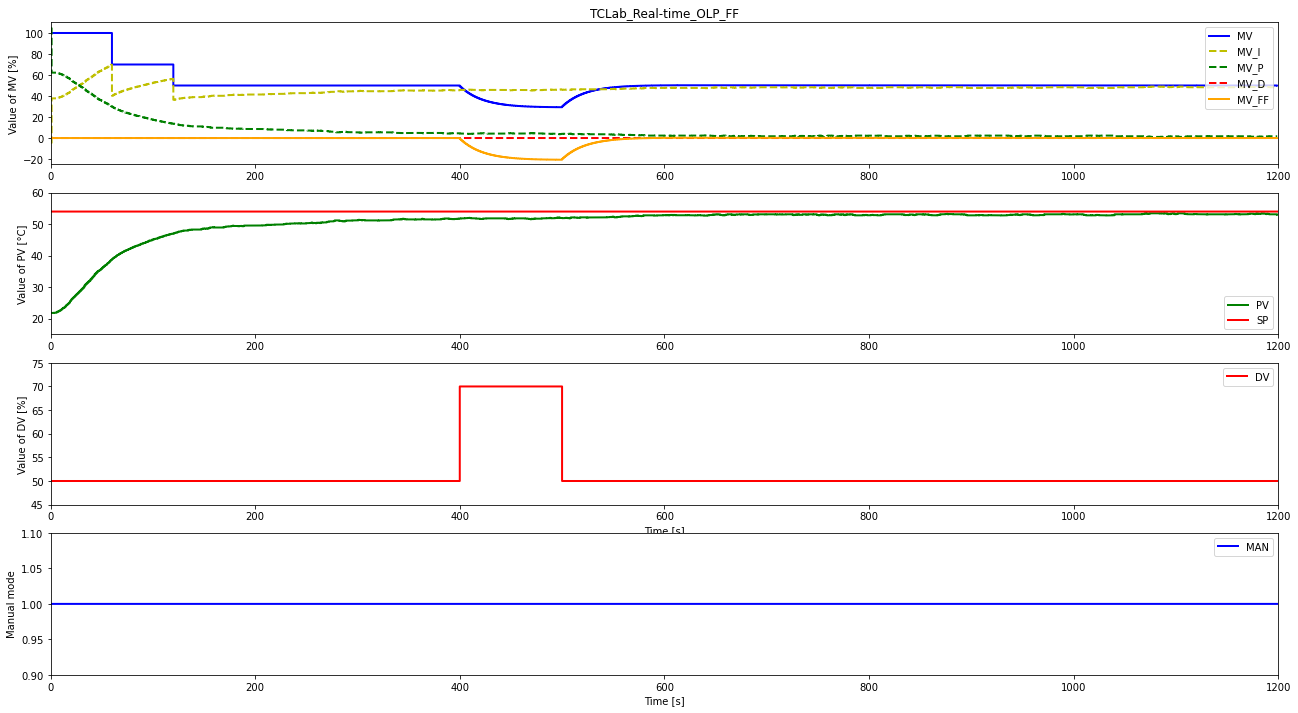

TCLab disconnected successfully.


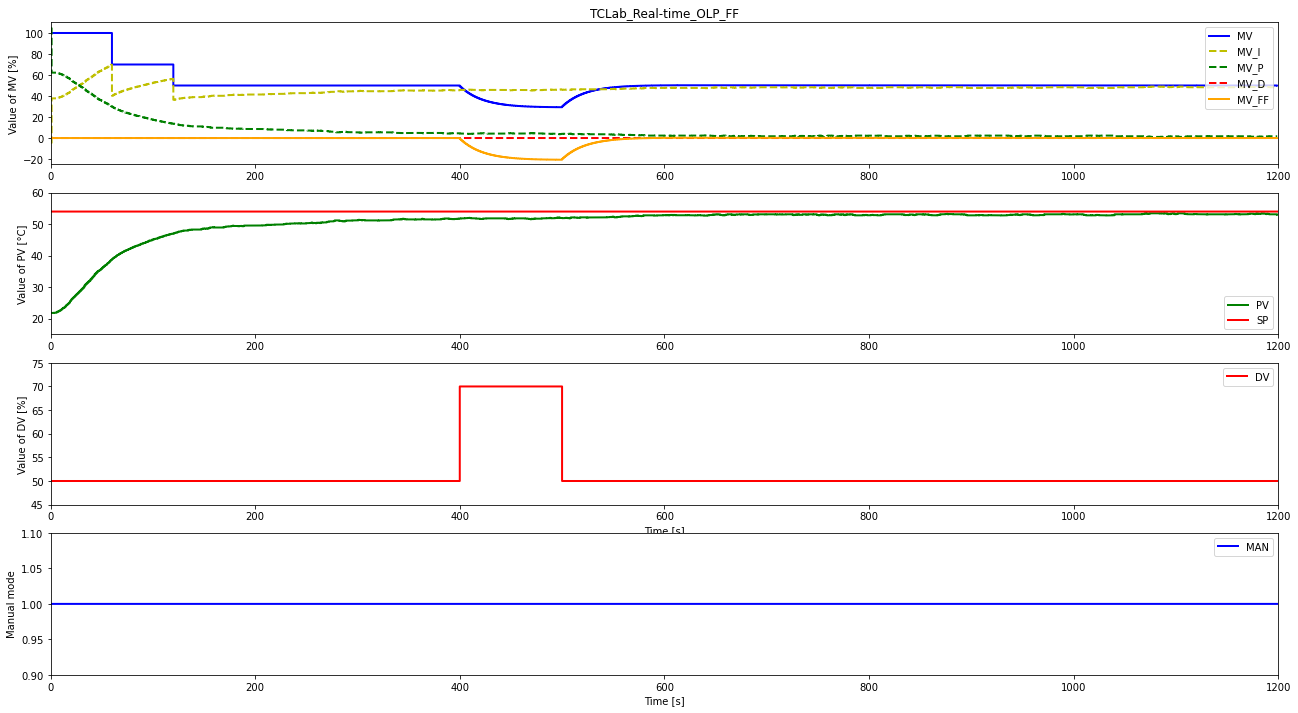

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[-30,100],'b-',linewidth=2,label='MV',where='post')
l5, = ax1.step([0,1],[-30,100],'y--',linewidth=2,label='MV_I',where='post')
l6, = ax1.step([0,1],[-30,100],'g--',linewidth=2,label='MV_P',where='post')
l7, = ax1.step([0,1],[-30,100],'r--',linewidth=2,label='MV_D',where='post')
l8, = ax1.step([0,1],[-30,100],'orange',linewidth=2,label='MV_FF',where='post')

ax1.set_ylabel('Value of MV [%]')
ax1.set_title('TCLab_Real-time_'+selectmode)
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
l4, = ax2.step([0,1],[0,100],'r-',linewidth=2,label='SP',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

l9, = ax4.step([0,1],[0,1],'b-',linewidth=2,label='MAN',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Manual mode')
ax4.legend(loc='best')

lab = tclab.TCLab()



# Experiment is started
while Exp:
    t.append(i*Ts)
    
    # SP et DV creation
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)
    
     #feedforward 

    if FF== True:
        FF_RT(DV, thetad, thetap, Ts, MVFFDelay, KFF, T1p, T1d, MVFFLL1, T2p, T2d, MV_FF, DV0)
    else:
        LL_RT(DV,0,T2p,T2d,Ts,MV_FF)
    
    #mode manuel
    SelectPath_RT(ManPath,t,MAN)
    SelectPath_RT(MVManPath,t,MV_MAN)
    
    #PID
    PID_RT(SP,PV,MAN,MV_MAN,MV_FF,Kc,T_I,T_D,alpha,Ts,MV_MAX,MV_MIN,MV,MV_P,MV_I,MV_D,E,FF)
    
    # Update TCLab
    
    lab.Q1(MV[-1]) 
    lab.Q2(DV[-1])
    
    
    PV.append(lab.T1) 
    time.sleep(Ts)
    
    
    l1.set_data(t,MV)
    l2.set_data(t,PV)
    l3.set_data(t,DV)
    l4.set_data(t,SP)
    l5.set_data(t,MV_I)
    l6.set_data(t,MV_P)
    l7.set_data(t,MV_D)
    l8.set_data(t,MV_FF)
    l9.set_data(t,MAN)

    
    clear_output(wait=True)    
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    if i > 1:
        min_MV =np.min([np.min(MV),np.min(MV_P),np.min(MV_I),np.min(MV_D), np.min(MV_FF)])
        max_MV =np.max([np.max(MV),np.max(MV_P),np.max(MV_I),np.max(MV_D), np.max(MV_FF)])
        ax1.set_ylim(myRound(np.min(min_MV),5)-5, myRound(max_MV,5)+5)
        ax2.set_ylim(myRound(np.min([np.min(PV),np.min(SP)]),5)-5, myRound(np.max([np.max(PV),np.max(SP)]),5)+5)
        ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5) 
        ax4.set_ylim(myRound(np.min(MAN),0.1)-0.1, myRound(np.max(MAN),0.1)+0.1) 
    
    display(fig)     
    
    i = i + 1
    
    if i == TSim:
        Exp = False
        lab.close()

# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array

t = np.array(t) 
MV = np.array(MV)
MV_P = np.array(MV_P)
MV_I = np.array(MV_I)
MV_D = np.array(MV_D)
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
MAN =np.array(MAN)

#t.T,MV.T,PV.T,DV.T
my_data = np.vstack((t.T,MV.T,MV_P.T,MV_I.T,MV_D.T,SP.T,PV.T,DV.T,MAN.T))
my_data = my_data.T
nameFile = 'Data/TCLab_'+selectmode+'_' + date_time+ '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man',comments='')        


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'TCLab_'+selectmode+'_' + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
    